## Project 5

In this project, we address the task of learning control policies for text-based games using reinforcement learning. In these games, all interactions between players and the virtual world are through text. The current world state is described by elaborate text, and the underlying state is not directly observable. Players read descriptions of the state and respond with natural language commands to take actions.

For this project you will conduct experiments on a small Home World, which mimic the environment of a typical house.The world consists of a few rooms, and each room contains a representative object that the player can interact with. For instance, the kitchen has an apple that the player can eat. The goal of the player is to finish some quest. An example of a quest given to the player in text is You are hungry now . To complete this quest, the player has to navigate through the house to reach the kitchen and eat the apple. In this game, the room is hidden from the player, who only receives a description of the underlying room. At each step, the player read the text describing the current room and the quest, and respond with some command (e.g., eat apple ). The player then receives some reward that depends on the state and his/her command.

In order to design an autonomous game player, we will employ a reinforcement learning framework to learn command policies using game rewards as feedback. Since the state observable to the player is described in text, we have to choose a mechanism that maps text descriptions into vector representations. A naive approach is to create a map that assigns a unique index for each text description. However, such approach becomes difficult to implement when the number of textual state descriptions are huge. An alternative method is to use a bag-of-words representation derived from the text description. This project requires you to complete the following tasks:

1. Implement the tabular Q-learning algorithm for a simple setting where each text description is associated with a unique index.
2. Implement the Q-learning algorithm with linear approximation architecture, using bag-of-words representation for textual state description.
3. Implement a deep Q-network.
4. Use your Q-learning algorithms on the Home World game.

-----------------

### 2. Home World Game

#### Optimal Episodic Reward

In [1]:
# Number of rooms
rooms = 4

# Quests
quests = 4

# Discount factor
gamma = 0.5

# Total number of "room-quest" pairs
pairs = rooms * quests


# Lets analyze one case: Starting in the living room
# - Living - Q:Living   = Correct command in 1 step = +1
# - Living - Q:Garden   = 1 step (No discount) + action (Reward * gamma) = -0.01 + 1*0.5
# - Living - Q:Bedroom  = 1 step (No discount) + action (R * gamma) = -0.01 + 1*0.5
# - Living - Q:Kitchen  = 2 step (1st - No discount / 2nd - discounted) + action (R * gamma) = -0.01 - 0.01*0.5 + 1*0.5^2

# Since we want the "optimal" reward, we assume that the agent behaves perfectly with
# no errors. This means that it only moves the exact number of steps required to get to
# its goal and then immediately executes the correct action. Assuming this, we have three 
# cases: One that requires no steps, one that requires 1 step and one that requires 2 steps
# to reach the quest's goal. This repeats a total of 4 times since the map is a square: No
# mater the starting room, you will always require 0 steps to get to the goal if its in the
# same room, 1 step to get to the two adjacent rooms and 2 steps to get to the room found in
# the opposite room of the map.

# ===========================
# OPTIMAL VALUE

# NOTES:
# 1. The probability of each "room-quest" occurring is 1/16 because there are 16
#    different "pairs" and each one has an equal probability of occurring.
# 2. Remember that the expected value is equal to the quantity that we are trying to
#    get the expected value from (In this case the optimal Value V*), weighted by the
#    probability of said event ocurring in the first place. We just sum all of the 
#    weighted terms for each "room-quest" pair and we have the total value V*

# Zero steps are required to get to the goal
# V*(0 Steps) = 1/16 * 1
EV_star_0 = 1/pairs * 1

# One step required to get to the goal
# V*(1 Steps) = 1/24 * (-0.01 + 1*0.5) * 2 (There are 2 cases where 1 step is needed)
EV_star_1 = 2/pairs * (-0.01 + 1 * gamma)

# Two steps required to get to the goal
# V*(2 Steps) = 1/24 * (-0.01 - 0.01*0.5 + 1*0.5^2)
EV_star_2 = 1/16 * (-0.01 - 0.01*gamma + 1 * gamma**2)

# We multiply by 4 because we have 4 starting rooms
EV_star = 4* ( EV_star_0 + EV_star_1 + EV_star_2 )
print("Expected Optimal Reward (E[V*]):", EV_star)

Expected Optimal Reward (E[V*]): 0.55375


--------------

### 3. Q-Learning Algorithm

#### Initialization

Here, configure the parameters used for the next 4 sections.

In [34]:
import numpy as np
from typing import Tuple

# Constants
GAMMA = 0.5             # discounted factor
ALPHA = 0.1             # learning rate for training

# Epsilon
TRAINING_EP = 0.5       # epsilon-greedy parameter for training
TESTING_EP = 0.05       # epsilon-greedy parameter for testing

# Runs, epochs and episodes
NUM_RUNS = 10           # Number of train-test sequences we will use to average performance
NUM_EPOCHS = 200        # Number of times we will train and test our agent
NUM_EPIS_TRAIN = 25     # number of episodes for training at each epoch
NUM_EPIS_TEST = 50      # number of episodes for testing

#### Single Step Update

In [35]:
def tabular_q_learning(
    q_func : np.ndarray, 
    current_state_1 : int, current_state_2 : int, 
    action_index : int,
    object_index : int, 
    reward : float, 
    next_state_1 : int, next_state_2 : int,
    terminal : bool
) -> None:
    """
    Update q_func for a given transition

    Args:
        q_func (np.ndarray): current Q-function
        current_state_1 (int): index of the current room (S_r)
        current_state_2 (int): index of the current quest (S_q)
        action_index (int): index of the current action
        object_index (int): index of the current object
        reward (float): the immediate reward the agent receives from playing current command
        next_state_1 (int): index describing the next room (S'_r) 
        next_state_2 (int,): index describing the next quest (S'_q)
        terminal (bool): True if this episode is over

    Returns:
        None
    """
    # Constants
    ALPHA = 1           # Exponential running average constant
    GAMMA = 0.5         # Discount factor

    # Shorter names for states and actions
    sr : int = current_state_1
    sq : int = current_state_2
    a : int = action_index
    b : int = object_index
    sr_prime : int = next_state_1
    sq_prime : int = next_state_2

    # This is the last step in the episode there are no "future events"
    if terminal:

        # We set the max value for all future actions to zero, since there are no more
        # actions after this
        max_Q_next = 0
    
    else: 

        # Get the maximum Q value that we can get from taking one of the C' possible
        # actions (a, b)
        max_Q_next = np.max(q_func[sr_prime, sq_prime, :, :])
    
    # Update according to the Q-learning algorithm
    # - q_func[sr, sq, a, b] : scalar
    # - reward : scalar
    # - max_Q : scalar
    q_update = (1 - ALPHA) * q_func[sr, sq, a, b] + (ALPHA) * (reward + GAMMA * max_Q_next)

    # Q(s, c) = updated Q(s, c)
    # - s = (sr, sq)
    #   sr: (current_state_1) Current room
    #   sq: (current_state_2) Current quest
    # - c = (a, b)
    #   a: (action_index) Action to execute
    #   b: (object_index) Object that will "receive" the action to execute (ie. eat APPLE)
    q_func[current_state_1, current_state_2, action_index, object_index] = q_update

    # This function shouldn't return anything
    return None  



#### Epsilon-greedy Exploration

Note that the Q-learning algorithm does not specify how we should interact in the world so as to learn quickly. It merely updates the values based on the experience collected. If we explore randomly, i.e., always select actions at random, we would most likely not get anywhere. A better option is to exploit what we have already learned, as summarized by current Q-values. We can always act greedily with respect to the current estimates, i.e., take an action $\pi (s)=\arg \max _{c\in C}Q(s,c)$. Of course, early on, these are not necessarily very good actions. For this reason, a typical exploration strategy is to follow a so-called -greedy policy: with probability $\epsilon$ take a random action out of $C$ with probability $1-\epsilon$ follow $\pi (s)=\arg \max _{c\in C}Q(s,c)$. The value of $\epsilon$ here balances exploration vs exploitation. A large value of  means exploring more (randomly), not using much of what we have learned. A small $\epsilon$, on the other hand, will generate experience consistent with the current estimates of Q-values.

Now you will write a function `epsilon_greedy` that implements the -greedy exploration policy using the current Q-function.

In [36]:
def epsilon_greedy(
    state_1 : int,
    state_2 : int,
    q_func : np.ndarray, 
    epsilon : float
) -> Tuple[int, int]:
    """
    Returns an action selected by an epsilon-Greedy exploration policy

    Args:
        state_1 (int): Index describing the current room (Sr)
        state_2 (int): Index describing the current quest (Sq)
        q_func (np.ndarray): current Q-function (4D array)
        epsilon (float): the probability of choosing a random command

    Returns:
        (int, int): the indices describing the action/object to take (a, b) where 
        "a" is the action and "b" is the object on which to act upon.
    """

    # Variable aliases
    sr : int = state_1
    sq : int = state_2

    # We generate a random number between 0 and 1. If that number is smaller than (1- epsilon)
    # we exploit. In any other case, we explore.
    random_number : float = np.random.random_sample()
    greedy : bool = (random_number < (1-epsilon))

    # Exploit (Greedy action):
    # Take the best possible action according to the current policy Pi(s)
    if greedy:

        # All possible actions for a given state S (2D array)
        q_s : np.ndarray = q_func[sr, sq, :, :]

        # Greedy action (Action C (a,b) that maximizes the Q value)
        # NOTE: "argmax" flattens the 2D array and returns the linear index that corresponds
        # to the highest value in that 2D array. We use "unravel_index" to convert that linear
        # index back to a 2D index
        pi_s = np.unravel_index(np.argmax(q_s), q_s.shape)

        # We extract the action and object from the policy for the current state (Pi(s))
        a, b = pi_s

    # Explore (Non-greedy action):
    # Take a random action from all the possible ones
    else:

        # Random action
        _, _, NUM_ACTIONS, NUM_OBJECTS = q_func.shape

        # Select a random action and object
        a : int = np.random.randint(NUM_ACTIONS)
        b : int = np.random.randint(NUM_OBJECTS)
     
    # Return a tuple "C" of an action and an object
    return (a, b)

-------

### 4. Tabular Q-Learning for Home World Game

In this section you will evaluate the tabular Q-learning algorithms for the Home world game. Recall that the state observable to the player is described in text. Therefore we have to choose a mechanism that maps text descriptions into vector representations.

In this section you will consider a simple approach that assigns a unique index for each text description. In particular, we will build two dictionaries:

- `dict_room_desc` that takes the room description text as the key and returns a unique scalar index
- `dict_quest_desc` that takes the quest description text as the key and returns a unique scalar index.

For instance, consider an observable state $s=(s_{r},s_{q})$, where $s_r$ and $s_q$ are the text descriptions for the current room and the current request, respectively. Then $i_{r}=$ dict_room_desc $[s_r]$ gives the scalar index for $s_r$ and $i_{q}=$ dict_quest_desc $[s_q]$ gives the scalar index for $s_q$. That is, the textual state $s = (s_r, s_q)$ is mapped to a tuple $I = (i_r, i_q)$.

Normally, we would build these dictionaries as we train our agent, collecting descriptions and adding them to the list of known descriptions. For the purpose of this project, these dictionaries will be provided to you.

#### Evaluating Tabular Q-learning on Home World

In [37]:
from rl.framework import make_all_states_index
from rl import framework

# Initialize the Q function values
q_func : np.ndarray = np.zeros((4, 4, 3, 7))

# Create the dictionaries that map text states to indexes
dict_room_desc, dict_quest_desc = make_all_states_index()

# Run a single episode
# NOTE: In this example we have multiple experiments or runs:
#   1. Run: Each run consists of multiple epochs
#   2. Epoch: In each epoch we train and test the agent for X episodes
#   3. Episode: Each episode consists of basically one go through the game
def run_episode(for_training):
    """ 
    Runs one episode
    If for training, update Q function
    If for testing, computes and return cumulative discounted reward

    Args:
        for_training (bool): True if for training

    Returns:
        None
    """

    # Use a different epsilon depending on whether the current run is for training or testing
    epsilon = TRAINING_EP if for_training else TESTING_EP

    # The reward for the current episode starts at 0
    episode_reward = 0

    # Discount
    # NOTE: Remember that in each episode the power of gamma increases by one.
    # This means that it starts with a power of zero (gamma^0 = 1) and then in each
    # step it increases by one (gamma^1 = gamma, gamma^2 = gamma^2, ...)
    episode_gamma = 1

    # Initialize a new game, we get back:
    # - Description of the initial room
    # - A description of the quest for this episode
    # - A variable indicating if the game is done (Initially false to indicate that its starting)
    (current_room_desc, current_quest_desc, terminal) = framework.newGame()


    while not terminal:

        # Map from a description (Sr, Sq) to an index (ir, iq) like the ones used previously
        ir : int = dict_room_desc[current_room_desc]
        iq : int = dict_quest_desc[current_quest_desc]

        # Choose an action using the epsilon-greedy method
        action_index, object_index = epsilon_greedy(ir, iq, q_func, epsilon)

        # Aliases for the action and object indexes
        a = action_index
        b = object_index

        # Run a step of the game. This returns:
        # - Future room description (S'r)
        # - Future quest description (S'q)
        # - Reward (R)
        # - Terminal: Whether the game has finished or not
        next_room_desc, next_quest_desc, reward, terminal = framework.step_game(current_room_desc, current_quest_desc, a, b)

        # Map from next state descriptions to indices
        ir_prime : int = dict_room_desc[next_room_desc]
        iq_prime : int = dict_quest_desc[next_quest_desc]

        # Aliases for states
        sr = ir
        sq = iq
        sr_prime = ir_prime
        sq_prime = iq_prime

        if for_training:

            # Update the Q function
            # NOTE: The update gets done "in place" meaning that we dont have to return anything
            # the Q function get updated inside the function
            tabular_q_learning(q_func, sr, sq, a, b, reward, sr_prime, sq_prime, terminal)

        if not for_training:
            
            # Calculate the discounted reward
            episode_reward += reward * episode_gamma

            # Increase the power of the gamma used for next episode
            episode_gamma *= GAMMA

        # The current "next_step" will consist of the "current_step" in the
        # next pass of the while loop
        current_room_desc = next_room_desc
        current_quest_desc = next_quest_desc

    if not for_training:
        return episode_reward


#### Report Performance

In [62]:
from rl import agent_tabular_ql

import importlib
importlib.reload(agent_tabular_ql)
importlib.reload(framework)

<module 'rl.framework' from 'e:\\Archivos\\Educación\\Posgrado\\Data Science (Universidad Galileo)\\2022 (MITx)\\Machine Learning with Python\\Unit 5\\Project 5\\rl\\framework.py'>

Avg reward: 0.484292 | Ewma reward: 0.534427: 100%|█| 200/200 [00:01<00:00, 107.
Avg reward: 0.486129 | Ewma reward: 0.520921: 100%|█| 200/200 [00:01<00:00, 107.
Avg reward: 0.491453 | Ewma reward: 0.524150: 100%|█| 200/200 [00:01<00:00, 109.
Avg reward: 0.489550 | Ewma reward: 0.532649: 100%|█| 200/200 [00:01<00:00, 108.
Avg reward: 0.473794 | Ewma reward: 0.507598: 100%|█| 200/200 [00:01<00:00, 104.
Avg reward: 0.494420 | Ewma reward: 0.524667: 100%|█| 200/200 [00:01<00:00, 108.
Avg reward: 0.498283 | Ewma reward: 0.518776: 100%|█| 200/200 [00:01<00:00, 112.
Avg reward: 0.493017 | Ewma reward: 0.514961: 100%|█| 200/200 [00:01<00:00, 111.
Avg reward: 0.489837 | Ewma reward: 0.522786: 100%|█| 200/200 [00:01<00:00, 109.
Avg reward: 0.498381 | Ewma reward: 0.528683: 100%|█| 200/200 [00:01<00:00, 108.


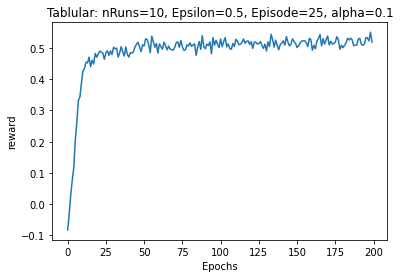

In [63]:
from rl.agent_tabular_ql import run
import matplotlib.pyplot as plt

# Convert all the possible descriptions for a quest and room into
# dictionaries that map the text with an index
(dict_room_desc, dict_quest_desc) = framework.make_all_states_index()

# Based on the dictionary created get the number or room descriptions and quests
NUM_ROOM_DESC = len(dict_room_desc)
NUM_QUESTS = len(dict_quest_desc)

# Set up the game
framework.load_game_data()

# All the rewards retrieved from all the tests done in each run, for every epoch
# shape NUM_RUNS * NUM_EPOCHS
epoch_rewards_test = []  

# Run the game and add a new "total cumulative reward"
for _ in range(NUM_RUNS):
    epoch_rewards_test.append(run(NUM_ROOM_DESC, NUM_QUESTS, dict_room_desc, dict_quest_desc))

# Turn the list of rewards into an array
epoch_rewards_test = np.array(epoch_rewards_test)

# =======================
# PLOT

# X-axis: One tick per epoch
x = np.arange(NUM_EPOCHS)

# New plot
fig, axis = plt.subplots()

# Plot reward per epoch averaged per run
axis.plot(x, np.mean(epoch_rewards_test, axis=0))  
axis.set_xlabel('Epochs')
axis.set_ylabel('reward')
axis.set_title(f'Tablular: nRuns={NUM_RUNS}, Epsilon={TRAINING_EP}, Episode={NUM_EPIS_TRAIN}, alpha={ALPHA}')
plt.show()